--- 
description: Here we show how to solve clique cover problems using JijZept and JijModeling.
---

# Clique Cover Problem

Here we show how to solve clique cover problems using JijZept and JijModeling. 
This problem is also mentioned in 6.2. Clique Cover on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is the clique cover problem?

This problem is finding the minimum number of cliques (complete graphs) into which a given graph can be partitioned.
This problem is known as NP-complete.

### Complete graphs

A complete graph is a graph whose two vertices are all adjacent to each other (not including loops or multiple edges).
We show two examples below.

![](./assets/clique_cover_01.png)

As we mentioned before, a vertex in a complete graph is adjacent to all other vertices. 
A complete undirected graph $G = (V, E)$ has ${}_V C_2 = \frac{1}{2} V(V-1)$ edges, that is, the number of edges is equal to the number of combinations choosing two vertices from $V$.
Based on minimizing the difference in the number of edges from a complete graph, we describe a mathematical model for the clique cover problem.


## Construction of a mathematical model

First, we introduce binary variables $x_{v, n}$ which are 1 if vertex $v$ belongs to $n$-th subgraph and 0 otherwise.

### Constraint: the vertices must belong to one clique

In this problem, each vertex can belong to one subgraph.

$$
\sum_{n=0}^{N-1} x_{v, n} = 1 \quad  (\forall v \in V) \tag{1}
$$

### Objective function : minimize the difference in the number of edges from a complete graph

We consider $n$-th subgraph $G (V_n, E_n)$. 
If this subgraph is complete, the number of edges of this subgraph is $\frac{1}{2} V_n (V_n -1)$ from the previous discussion. 
In face, $n$-th subgraph has $\sum_{(uv) \in E_n} x_{u, n} x_{v, n}$ edges.
The more difference between the two is zero, the closer a subgraph is to a clique.
Therefore, we set the objective function as follows.

$$
H
= \sum_{n=0}^{N-1} \left\{ \frac{1}{2} \left( \sum_{v=0}^{V-1} x_{v, n} \right) \left( \sum_{v=0}^{V-1} x_{v, n} -1\right) - \sum_{(uv) \in E} x_{u, n} x_{v, n} \right\} \tag{2}
$$

## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
N = jm.Placeholder('N')
x = jm.BinaryVar('x', shape=(V, N))
n = jm.Element('n', belong_to=(0, N))
v = jm.Element('v', belong_to=(0, V))
e = jm.Element('e', belong_to=E)

We use the same variables in the graph coloring problem.

### Constraint

We implement a constraint Equation (1).

In [2]:
# set problem
problem = jm.Problem('Clique Cover')
# set one-hot constraint: each vertex has only one color
problem += jm.Constraint('color', x[v, :].sum()==1, forall=v)

`x[v, :].sum()` is equivalent to `sum(n, x[v, n])`.

### Objective function

Next, we implement an objective function Equation (2).

In [3]:
# set objective function: minimize the difference in the number of edges from complete graph
clique = x[:, n].sum() * (x[:, n].sum()-1) / 2
num_e = jm.sum(e, x[e[0], n]*x[e[1], n])
problem += jm.sum(n, clique-num_e)

Let's display the implemented mathematical model in Jupyter Notebook.

In [4]:
problem

## Prepare an instance

We prepare a graph using [Networkx](https://networkx.org/).

In [14]:
import networkx as nx

# set the number of colors
inst_N = 3
# set empty graph
inst_G = nx.Graph()
# add edges
inst_E = [[0, 1], [1, 2], [0, 2], 
            [3, 4], [4, 5], [5, 6], [3, 6], [3, 5], [4, 6], 
            [7, 8], [8, 9], [7, 9], 
            [1, 3], [2, 6], [5, 7], [5, 9]]
inst_G.add_edges_from(inst_E)
# get the number of nodes
inst_V = list(inst_G.nodes)
num_V = len(inst_V)
instance_data = {'N': inst_N, 'V': num_V, 'E': inst_E}

This graph for the clique cover problem is shown below.

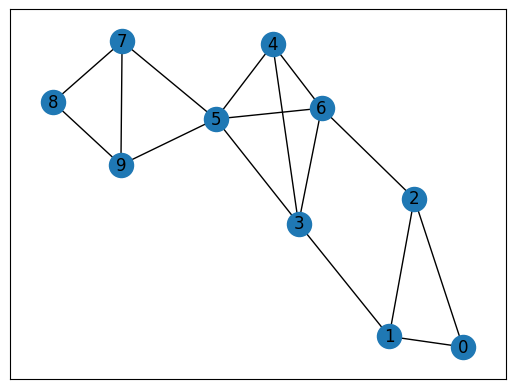

In [15]:
import matplotlib.pyplot as plt

nx.draw_networkx(inst_G, with_labels=True)
plt.show()

This graph has 3 cliques (0, 1, 2), (3, 4, 5, 6), and (7, 8, 9). 
In the next section, let's try to detect these 3 cliques with JijZept.

## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [16]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="config.toml")
# solve problem
multipliers = {'color': 1.0}
results = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

## Visualize the solution

In the end, we extract the lowest energy solution from the feasible solutions and visualize it.

Objective: 0.0


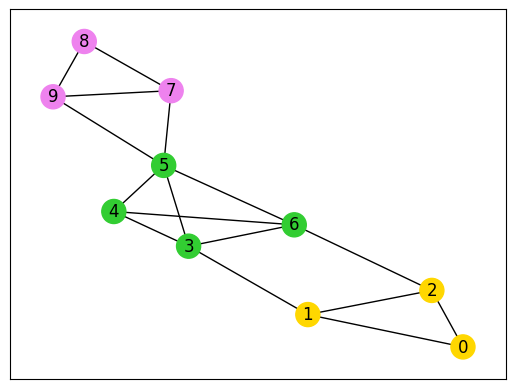

In [17]:
# extract feasible solution
feasible = results.feasible()
if feasible.evaluation.objective.size == 0:
    print('No feasible solution found ...')
else:
    print("Objective: "+str(feasible.evaluation.objective[0]))
    # get indices of x = 1
    indices, _, _ = feasible.record.solution['x'][0]
    # get vertex number and color
    vertices, colors = indices
    # sort lists by vertex number
    zip_lists = zip(vertices, colors)
    zip_sort = sorted(zip_lists)
    sorted_vertices, sorted_colors = zip(*zip_sort)
    # initialize vertex color list
    node_colors = [-1] * len(vertices)
    # set color list for visualization
    colorlist = ['gold', 'violet', 'limegreen']    
    # set vertex color list
    for i, j in zip(sorted_vertices, sorted_colors):
        node_colors[i] = colorlist[j]
    # make figure
    nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
    plt.show()

As we expected, JijZept successfully split this graph into 3 cliques.